In [1]:
#setup - rememeber to switch to tensorflow 2.3 kernel...
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import trimesh
import time
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

2.9.1


Autosaving every 180 seconds


In [2]:
#load OFF file from ModelNet10 dir
start = time.time()
fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_0069.off'
# fn = 'C:/Users/Derm/Desktop/big/ModelNet10/sofa/train/sofa_0370.off'
# fn = 'C:/Users/Derm/Desktop/big/ModelNet10/bed/train/bed_0320.off'


M = trimesh.load(fn)
test = trimesh.sample.sample_surface(M, 100)
print("took ", time.time() - start, "seconds")

took  0.021000385284423828 seconds


In [3]:
#use Vedo to plot OG and subsampled surfaces
plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []

# disp.append(Points(M.vertices, c = 'blue', r = 4))
disp.append(Points(test[0], c = 'red', r = 5))
toilet = Mesh(M).c("gray").alpha(0.2)
disp.append(toilet)

# disp.append(Points(x_train[50,:,:].numpy(), c = 'blue', r = 5)) #test drawing unknown point cloud

plt1.show(disp, "surface sampling test")
ViewInteractiveWidget(plt1.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [4]:
#define rotation matrix used to transform point clouds
def R_tf(angs):
    if len(tf.shape(angs)) == 1:
        angs = angs[None,:]
    phi = angs[:,0]
    theta = angs[:,1]
    psi = angs[:,2]
    mat = tf.Variable([[cos(theta)*cos(psi), sin(psi)*cos(phi) + sin(phi)*sin(theta)*cos(psi), sin(phi)*sin(psi) - sin(theta)*cos(phi)*cos(psi)],
                       [-sin(psi)*cos(theta), cos(phi)*cos(psi) - sin(phi)*sin(theta)*sin(psi), sin(phi)*cos(psi) + sin(theta)*sin(psi)*cos(phi)],
                       [sin(theta), -sin(phi)*cos(theta), cos(phi)*cos(theta)]
                        ])
    mat = tf.transpose(mat, [2, 0, 1])
    mat = tf.squeeze(mat)
    return mat

# determine euler angles from rotation matrix
def R2Euler(mat):
    if len( tf.shape(mat) ) == 2:
        mat = mat[None, :, :]
    R_sum = np.sqrt(( mat[:,0,0]**2 + mat[:,0,1]**2 + mat[:,1,2]**2 + mat[:,2,2]**2 ) / 2)
    phi = np.arctan2(-mat[:,1,2],mat[:,2,2])
    theta = np.arctan2(mat[:,0,2], R_sum)
    psi = np.arctan2(-mat[:,0,1], mat[:,0,0])
    angs = np.array([phi, theta, psi])
    return angs

In [ ]:
#generate toy dataset using all of the toilets in the ModelNet10 repository
numMeshes = 20 #300 #344
ptsPerCloud = 100 #was 25 in OG method 
iterPerMesh = 100 #number of times to sample clouds from each mesh

#init vector to store sampled point clouds
x = np.zeros([numMeshes*iterPerMesh, ptsPerCloud*2, 3])
#init vector to store transformations 
y = np.zeros([numMeshes*iterPerMesh, 6]) #rotation and translation
# y = np.zeros([numMeshes*iterPerMesh, 3]) #if only considering translations

#scale trans and rotation params so outputs are equally weighted
trans_scale = 10.0 #2.0
rot_scale = 0.2 #0.2

for i in range(numMeshes):
    if i % 2 == 0:
        print(i)
    fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_%04d.off' %(i+1) #loop through file names
#     fn = 'C:/Users/Derm/Desktop/big/ModelNet10/bed/train/bed_0059.off'
#     fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_0069.off' #debug -> only use single toilet model
    M = trimesh.load(fn)

    #more efficient to sample all points at once and then just use some for each frame
    sam1 = trimesh.sample.sample_surface(M, iterPerMesh*ptsPerCloud)[0] #get keyframe scan
    sam2 = trimesh.sample.sample_surface(M, iterPerMesh*ptsPerCloud)[0] #get new scan
#     sam2 = sam1 + 0.01*np.random.randn(np.shape(sam1)[0], 3) #copy point locations and add some noise
    
    for j in range(iterPerMesh):
        #rotate keyframe
        angs1 = 0.5*tf.random.normal([3])
        rot1 = R_tf(angs1)
        #rotate scan 2 relative to keyframe
        angs2 = rot_scale*tf.random.normal([3])
#         rot2 = R_tf(angs1 + angs2) #was this (wrong??)
        angs2 = tf.zeros([3]) # ~~~~~~~~~~~~~~~ zero out rotation (for debug) ~~~~~~~~~~~~~~~~~~~~~~
#         rot2 = tf.matmul(R_tf(angs1), R_tf(angs2)) #was this (wrong??)
        rot2 = tf.matmul(R_tf(angs2), R_tf(angs1)) #test

        
        # randomly grow/shrink each point cloud before translation
        scale = 1. + 0.2*tf.random.normal([1])[0]

        x[i*iterPerMesh + j, :ptsPerCloud, :] = sam1[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot1.numpy())*scale           
            
        trans = trans_scale*tf.random.normal([3])
        #was this (incorrect for large angle deviation?)
#         sam2_j = trans + sam2[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot1.numpy()).dot(rot2.numpy())*scale 
        sam2_j = trans + sam2[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot2.numpy())*scale 
        x[i*iterPerMesh + j, ptsPerCloud:, :] = sam2_j

        #save transformation as y
        y[i*iterPerMesh + j,:3] = trans.numpy()/trans_scale
        y[i*iterPerMesh + j,3:] = angs2.numpy()/rot_scale

In [ ]:
#split into train and test sets, save to file
split = 0.9
x_train = x[:int(split*np.shape(x)[0])]
# np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_train', x_train)
x_test = x[int(split*np.shape(x)[0]):]
# np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_test', x_test)
y_train = y[:int(split*np.shape(y)[0])]
# np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_train', y_train)
y_test = y[int(split*np.shape(y)[0]):]
# np.save('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_test', y_test)

print(np.shape(x_train))

In [5]:
#load data from memory
numMeshes = 300 #344
ptsPerCloud = 256 #50 #was 25 in OG method 
iterPerMesh = 200 #100  #number of times to sample clouds from each mesh
trans_scale = 10.0 #2.0
rot_scale = 0.2 #0.2

# x_train = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_train.npy')
# y_train = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_train.npy')
# x_test = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_test.npy')
# y_test = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_test.npy')

x_train = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_train_trans_only.npy')
y_train = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_train_trans_only.npy')
x_test = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/x_test_trans_only.npy')
y_test = np.load('C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/y_test_trans_only.npy')

#limit ptsPerCloud of loaded data -----------------------------------
halflen = np.shape(x_train)[1]//2
x_train = np.concatenate((x_train[:,:ptsPerCloud,:], x_train[:,halflen:(halflen + ptsPerCloud),:]), axis = 1)
halflen = np.shape(x_test)[1]//2
x_test = np.concatenate((x_test[:,:ptsPerCloud,:], x_test[:,halflen:(halflen + ptsPerCloud),:]), axis = 1)
print(np.shape(x_train)) #starts out at 256 per cloud
print(np.shape(y_train)) 
print(np.shape(x_test))
print(np.shape(y_test))
#---------------------------------------------------------------------


(54000, 512, 3)
(54000, 6)
(6000, 512, 3)
(6000, 6)


### Load Lidar Data (Alternate Option) 

In [ ]:
#Train on data generated from KITTI dataset
#(from drive 005 snippet)
# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan1_50_shifted.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan2_50_shifted.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_ground_truth_50_shifted.txt")

# #full urban drive (much larger)
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_scan1_to400.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_scan2_to400.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_ground_truth_to400.npy")

# toy data set generated in MatLab
d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan1_1k.txt")
d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan2_1k.txt")
gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ground_truth_1k.txt")

points_per_sample = 50  #num pts per scan - defined in MatLab script
scan1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
scan2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
gt = tf.convert_to_tensor(gt)

#split data into training and validation sets
tsplit = 0.95 #this fraction goes into training
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())
x_train = tf.concat((scan1[:ntrain], scan2[:ntrain]), axis = 1)
x_test = tf.concat((scan1[ntrain:], scan2[ntrain:]), axis = 1)
y_train = gt[:ntrain]
y_test = gt[ntrain:]

print(tf.shape(y_train))
y_train = tf.concat((y_train, tf.zeros(tf.shape(y_train), dtype = tf.double)), axis = 1)
# y_train = tf.concat((y_train, tf.zeros(tf.shape(y_train), dtype = tf.float32)), axis = 1)
print(tf.shape(y_train))
print(tf.shape(x_train))

In [ ]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)
print(tf.shape(x_train))
print(tf.shape(y_train))

#TEST
#just translation case ------------
# y_train = y_train[:,:3]
# print(tf.shape(y_train))
#----------------------------------

## Create TF dataset to augment data

In [6]:
def augment(points, gt):
    print(np.shape(points))
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points in first point cloud
    points = tf.concat([tf.random.shuffle(points[:256]), tf.random.shuffle(points[256:])], axis = 0)
#     print(test)
    return points, gt

NUM_POINTS = 256
BATCH_SIZE = 512

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(len(x_train)).map(augment).batch(BATCH_SIZE)
print(train_dataset)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.shuffle(len(x_test)).map(augment).batch(BATCH_SIZE)
print(val_dataset)

(512, 3)
<BatchDataset element_spec=(TensorSpec(shape=(None, 512, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>
(512, 3)
<BatchDataset element_spec=(TensorSpec(shape=(None, 512, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>


# Train Network

| MAE      | Batch Size     |    Epochs | Train Dataset | Notes | Network|
| ----------- | ----------- | --------- | --------   | | |
| 0.055  | 64 |  30   | toilet 69, 5k samles | 50 pts per scan    | Net |
| 0.067  | 16 |  30   | toilet 69, 1800 samles | 512 pts per scan    | Net |
| 0.11  | 64 |  30   | 20 toilets, 100 PCs each |no augmentation between epochs| Net |
| 0.065  | 64 |  30   | 20 toilets, 100 PCs each |Using tf.data.map(augment)| Net |

In [8]:
from network import Net #mine
# from network import PointNet as Net #uses builtin PointNetConv2Layer
# from network import PCRnet as Net #PCR-Net baseline
np.random.seed(1337)
runLen =  30

def scheduler(epoch, learning_rate):
    part1 = runLen//3
    part2 = 2*runLen//3 #net2
    if epoch < part1:
        learning_rate = 0.001
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.0005 #0.001
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.00005 #0.00025
        return learning_rate

model = Net()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.MeanAbsoluteError()) #was MeanAbsoluteError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("DermNet_ModelNet_benchmark_cp.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#was this
# trace = model.fit(x = x_train, y = y_train, batch_size = 64, epochs=runLen, verbose=1, 
#                   validation_split = 0.1, shuffle=True, callbacks = [cp,scheduler])
#best BS = 512??

#using TF.dataset.augmen
trace = model.fit(train_dataset, epochs=runLen, validation_data = val_dataset, 
                  verbose=1, callbacks = [cp,scheduler])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 3)]          0         
                                                                 
 tf.expand_dims_1 (TFOpLambd  (None, 512, 3, 1)        0         
 a)                                                              
                                                                 
 conv2d (Conv2D)             (None, 512, 1, 64)        256       
                                                                 
 batch_normalization_2 (Batc  (None, 512, 1, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 1, 64)        4160      
                                                                 
 batch_normalization_3 (Batc  (None, 512, 1, 64)       256 

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 19s 164ms/step - loss: 0.3741 - val_loss: 0.8355 - lr: 0.0010
Epoch 2/30
106/106 [==============================] - ETA: 0s - loss: 0.1471

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 18s 168ms/step - loss: 0.1471 - val_loss: 0.5688 - lr: 0.0010
Epoch 3/30
106/106 [==============================] - ETA: 0s - loss: 0.1238

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 19s 177ms/step - loss: 0.1238 - val_loss: 0.3157 - lr: 0.0010
Epoch 4/30
106/106 [==============================] - ETA: 0s - loss: 0.1140

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 18s 163ms/step - loss: 0.1140 - val_loss: 0.2341 - lr: 0.0010
Epoch 5/30
106/106 [==============================] - ETA: 0s - loss: 0.1038

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 17s 163ms/step - loss: 0.1038 - val_loss: 0.2049 - lr: 0.0010
Epoch 6/30
106/106 [==============================] - ETA: 0s - loss: 0.0997

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 17s 160ms/step - loss: 0.0997 - val_loss: 0.1773 - lr: 0.0010
Epoch 7/30
106/106 [==============================] - ETA: 0s - loss: 0.0940

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 18s 164ms/step - loss: 0.0940 - val_loss: 0.1646 - lr: 0.0010
Epoch 8/30
106/106 [==============================] - ETA: 0s - loss: 0.0873

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 18s 163ms/step - loss: 0.0873 - val_loss: 0.1343 - lr: 0.0010
Epoch 9/30
106/106 [==============================] - 15s 143ms/step - loss: 0.0839 - val_loss: 0.1532 - lr: 0.0010
Epoch 10/30
106/106 [==============================] - 16s 151ms/step - loss: 0.0834 - val_loss: 0.1473 - lr: 0.0010
Epoch 11/30
106/106 [==============================] - ETA: 0s - loss: 0.0697

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 18s 167ms/step - loss: 0.0697 - val_loss: 0.1136 - lr: 5.0000e-04
Epoch 12/30
106/106 [==============================] - ETA: 0s - loss: 0.0680

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 18s 163ms/step - loss: 0.0680 - val_loss: 0.0762 - lr: 5.0000e-04
Epoch 13/30
106/106 [==============================] - 16s 149ms/step - loss: 0.0646 - val_loss: 0.0819 - lr: 5.0000e-04
Epoch 14/30
106/106 [==============================] - 15s 141ms/step - loss: 0.0681 - val_loss: 0.1026 - lr: 5.0000e-04
Epoch 15/30
106/106 [==============================] - 15s 141ms/step - loss: 0.0650 - val_loss: 0.0993 - lr: 5.0000e-04
Epoch 16/30
106/106 [==============================] - 15s 142ms/step - loss: 0.0670 - val_loss: 0.1216 - lr: 5.0000e-04
Epoch 17/30
106/106 [==============================] - 15s 141ms/step - loss: 0.0667 - val_loss: 0.1000 - lr: 5.0000e-04
Epoch 18/30
106/106 [==============================] - 15s 143ms/step - loss: 0.0635 - val_loss: 0.0980 - lr: 5.0000e-04
Epoch 19/30
106/106 [==============================] - 16s 149ms/step - loss: 0.0646 - val_loss: 0.1195 - lr: 5.0000e-04
Epoch 20/30
106/106 [=======================

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 17s 163ms/step - loss: 0.0537 - val_loss: 0.0648 - lr: 5.0000e-05
Epoch 22/30
106/106 [==============================] - ETA: 0s - loss: 0.0515

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 18s 169ms/step - loss: 0.0515 - val_loss: 0.0630 - lr: 5.0000e-05
Epoch 23/30
106/106 [==============================] - ETA: 0s - loss: 0.0516

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 18s 165ms/step - loss: 0.0516 - val_loss: 0.0620 - lr: 5.0000e-05
Epoch 24/30
106/106 [==============================] - ETA: 0s - loss: 0.0518

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 17s 163ms/step - loss: 0.0518 - val_loss: 0.0618 - lr: 5.0000e-05
Epoch 25/30
106/106 [==============================] - 15s 142ms/step - loss: 0.0524 - val_loss: 0.0632 - lr: 5.0000e-05
Epoch 26/30
106/106 [==============================] - ETA: 0s - loss: 0.0515

INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


INFO:tensorflow:Assets written to: DermNet_ModelNet_benchmark_cp.kmod\assets


106/106 [==============================] - 17s 164ms/step - loss: 0.0515 - val_loss: 0.0568 - lr: 5.0000e-05
Epoch 27/30
106/106 [==============================] - 15s 142ms/step - loss: 0.0509 - val_loss: 0.0581 - lr: 5.0000e-05
Epoch 28/30
106/106 [==============================] - 15s 144ms/step - loss: 0.0513 - val_loss: 0.0600 - lr: 5.0000e-05
Epoch 29/30
106/106 [==============================] - 15s 143ms/step - loss: 0.0509 - val_loss: 0.0604 - lr: 5.0000e-05
Epoch 30/30
106/106 [==============================] - 15s 141ms/step - loss: 0.0503 - val_loss: 0.0617 - lr: 5.0000e-05


<IPython.core.display.Javascript object>


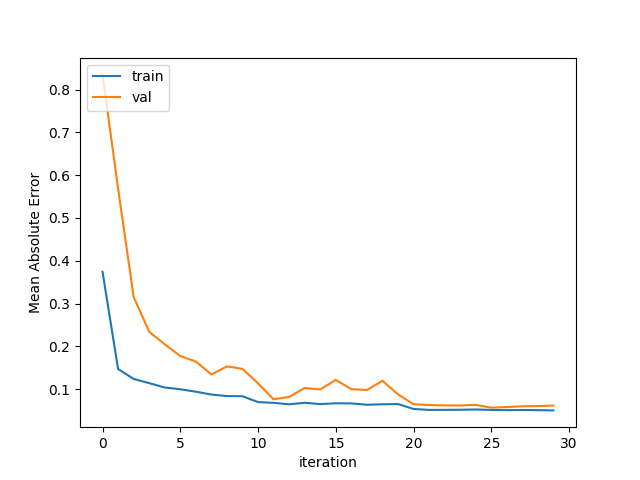

Text(0, 0.5, 'Mean Absolute Error')

In [9]:
# Network Loss Plots
from matplotlib import pyplot as plt
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('Mean Absolute Error')

In [10]:
#temp- get center location of each point cloud to make sure net isn't just matching centroids
idx = int(np.floor(100*np.random.randn()))
mu1 = tf.math.reduce_mean(x_train[idx, :ptsPerCloud, :], axis = 0)
mu2 = tf.math.reduce_mean(x_train[idx, ptsPerCloud:, :], axis = 0) - (y_train[idx,:3]*trans_scale)
print(mu1)
print(mu2)
center_error = mu1 - mu2
print(center_error)

tf.Tensor([-5.58008181  4.2474526   1.54906792], shape=(3,), dtype=float64)
tf.Tensor([-5.92326622  3.40196312  1.40976369], shape=(3,), dtype=float64)
tf.Tensor([0.3431844  0.84548947 0.13930423], shape=(3,), dtype=float64)


In [11]:
#look at errors at never-before-seen test data generated from similar objects in ModelNet10
guess = model.predict(x_train[:4])
error = y_train[:4] - guess
print(guess)
print(y_train[:4])
print(error)

1/1 [==============================] - 0s 330ms/step
[[ 3.6034173e-01  3.0419078e-01  1.0271007e+00  2.4722498e-03
   4.7277391e-04 -5.4686680e-05]
 [-1.1673863e+00 -3.8995641e-01  8.6279565e-01 -8.7316288e-04
   3.9807092e-03  1.8857124e-03]
 [ 3.0340341e-01 -6.6184324e-01 -7.5254649e-01 -3.8316869e-03
   7.1171962e-04 -3.3546514e-03]
 [-1.7223639e+00 -2.3635265e-01  7.6726502e-01 -1.8547336e-03
  -6.0966506e-04 -4.3083318e-03]]
[[ 0.42244235  0.30968952  1.08941162  0.          0.          0.        ]
 [-1.33839726 -0.4203828   0.93120605  0.          0.          0.        ]
 [ 0.30679035 -0.72255397 -0.76323378  0.          0.          0.        ]
 [-1.82219815 -0.24048337  0.81757659  0.          0.          0.        ]]
[[ 6.21006191e-02  5.49873710e-03  6.23109341e-02 -2.47224979e-03
  -4.72773914e-04  5.46866795e-05]
 [-1.71010971e-01 -3.04263830e-02  6.84103966e-02  8.73162877e-04
  -3.98070924e-03 -1.88571238e-03]
 [ 3.38694453e-03 -6.07107282e-02 -1.06872916e-02  3.83168692e-

In [12]:
#Generate special test data for this visualization (evenly sampled)
#  (doing this so we can draw the underlying model from which points were sampled)
fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_0310.off' #0310 looks best
# fn = 'C:/Users/Derm/Desktop/big/ModelNet10/toilet/train/toilet_0069.off' #simple shape
# fn = 'C:/Users/Derm/Desktop/big/ModelNet10/bed/train/bed_0250.off' 
# fn = 'C:/Users/Derm/Desktop/big/ModelNet10/sofa/train/sofa_0250.off' 

M = trimesh.load(fn)

n_tests = 1 #number of test samples to generate
#init vector to store sampled point clouds
x_test2 = np.zeros([n_tests, ptsPerCloud*2, 3])
#init vector to store transformations 
y_test2 = np.zeros([n_tests, 6]) #rotation and translation

sam1 = trimesh.sample.sample_surface(M, n_tests*ptsPerCloud)[0] #get keyframe scan
sam2 = trimesh.sample.sample_surface(M, n_tests*ptsPerCloud)[0] #get new scan

for j in range(n_tests):
    angs1 = 0.5*tf.random.normal([3])    #rotate keyframe
    rot1 = R_tf(angs1)
    angs2 = rot_scale*tf.random.normal([3])     #rotate scan 2 relative to keyframe
    angs2 = tf.zeros([3]) # ~~~~~~~~~~~~~~~ zero out rotation (for debug) ~~~~~~~~~~~~~~~~~~~~~~
    rot2 = R_tf(angs2)
    #     rot_combined = R_tf(angs1 + angs2) #was this
    rot_combined = tf.matmul(R_tf(angs1), R_tf(angs2))
    
    x_test2[j, :ptsPerCloud, :] = sam1[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot1.numpy())         

    trans = trans_scale*tf.random.normal([3])
    #was this
    sam2_j = trans + sam2[j*ptsPerCloud:(j+1)*ptsPerCloud].dot(rot_combined.numpy()) #transform scan
    #DEBUG
#     sam2_j = (sam2[j*ptsPerCloud:(j+1)*ptsPerCloud]+trans.numpy()).dot(rot_combined.numpy()) #transform scan
    x_test2[j, ptsPerCloud:, :] = sam2_j

    #save transformation as y
    y_test2[j,:3] = trans.numpy()/trans_scale
    y_test2[j,3:] = angs2.numpy()/rot_scale
print(tf.shape(x_test2))

tf.Tensor([  1 512   3], shape=(3,), dtype=int32)


In [13]:
#visualize network performance on evenly sampled data
t = 0 #test number to draw
niter = 5 #number of iterations to run network for

plt2 = Plotter(N = 3, axes = 4, bg = (1, 1, 1), interactive = True)
disp1 = [] #before estimated transformation (drawn on left)
disp2 = [] #after 1 transformation (drawn in center)
disp3 = [] #after niter transformations

#draw first viz (untransformed set of scans)-------------------
scan1 = Mesh(M).c("red").alpha(0.1)#.rotate(90, axis = (0,0,1))
scan1.applyTransform(rot1.numpy().T)
disp1.append(scan1)
disp1.append(Points(x_test2[0,:ptsPerCloud], c = 'red', r = 5))

scan2 = Mesh(M).c("blue").alpha(0.1)
scan2.applyTransform(rot_combined.numpy().T)
# scan2.pos(y_test2[t,0], y_test2[t,1], y_test2[t,2])
scan2.pos(y_test2[t,0]*trans_scale, y_test2[t,1]*trans_scale, y_test2[t,2]*trans_scale)
disp1.append(scan2)
disp1.append(Points(x_test2[0,ptsPerCloud:], c = 'blue', r = 5))

#FOR DEBUG - draw ground truth transformation in green so I can be sure which order is correct
# correct = (x_test2[0,ptsPerCloud:] - y_test2[0,:3]*trans_scale).dot(R_tf(y_test2[0,3:]*rot_scale).numpy().T)
# temp = Points(correct, c = 'green', r = 5)
# disp1.append(temp)
#---------------------------------------------------------------

#draw esatimated soln after 1 iteration ------------------------
ans_cum = model.predict(x_test2)[t]
ans_cum[:3] = ans_cum[:3]*trans_scale
ans_cum[3:] = ans_cum[3:]*rot_scale

#draw meshes
soln_est_rot = R_tf(ans_cum[3:])
scan2_transformed = Mesh(M).c("blue").alpha(0.1)
scan2_transformed.applyTransform(soln_est_rot.numpy().dot(rot_combined.numpy().T))
scan2_transformed.pos(y_test2[t,0]*trans_scale - ans_cum[0], 
                      y_test2[t,1]*trans_scale - ans_cum[1], 
                      y_test2[t,2]*trans_scale - ans_cum[2])
disp2.append(scan2_transformed)
disp2.append(Mesh(M).c("red").alpha(0.1).applyTransform(rot1.numpy().T)) #draw keyframe

#add points
scan2_pts_transformed = (x_test2[0,ptsPerCloud:] - ans_cum[:3]).dot(soln_est_rot.numpy().T)
# scan2_pts_transformed = (x_test2[0,ptsPerCloud:]).dot(soln_est_rot.numpy().T) - ans_cum[:3]
disp2.append(Points(scan2_pts_transformed, c = 'blue', r = 5))

disp2.append(Points(x_test2[0,:ptsPerCloud], c = 'red', r = 5))
gt = y_test2[t].copy()
gt[:3] = gt[:3]*trans_scale
gt[3:] = gt[3:]*rot_scale
print("\n ground truth:", gt)
print("\n estimate from DNN after 1 iteration:", ans_cum)
#-----------------------------------------------------------------

# draw estiamted soln after n interations-------------------------
#TODO: need to figure out more compat way of representing sequential 6DOF transforms
for i in range(niter):
    #replace initial scan2 with transformed pc2 as input to network
    inlayer = tf.concat([x_test2[0][:ptsPerCloud], scan2_pts_transformed], axis = 0)[None, :, :]
    ans_i = model.predict(inlayer)[0]
    ans_i[:3] = ans_i[:3]*trans_scale
    ans_i[3:] = ans_i[3:]*rot_scale
    
#     soln_est_rot = tf.matmul(R_tf(ans_i[3:]), soln_est_rot)
    soln_est_rot = R_tf(ans_i[3:]) #test
    ans_cum[:3] = ans_cum[:3] + ans_i[:3]
#     ans_cum[3:] = R2Euler(soln_est_rot)[:,0]
    ans_cum[3:] = R2Euler(tf.matmul(R_tf(ans_i[3:]), soln_est_rot))[:,0]
    scan2_pts_transformed = (x_test2[0,ptsPerCloud:] - ans_cum[:3]).dot(soln_est_rot.numpy().T)
    
# print("\n estimate from DNN after", niter, "iterations: ", ans_cum) 

scan2_transformed_again = Mesh(M).c("blue").alpha(0.1)
scan2_transformed_again.applyTransform(soln_est_rot.numpy().dot(rot_combined.numpy().T)) #test
scan2_transformed_again.pos(y_test2[t,0]*trans_scale - ans_cum[0], 
                            y_test2[t,1]*trans_scale - ans_cum[1], 
                            y_test2[t,2]*trans_scale - ans_cum[2])
disp3.append(scan2_transformed_again)
disp3.append(Points(scan2_pts_transformed, c = 'blue', r = 5))
disp3.append(Points(x_test2[0,:ptsPerCloud], c = 'red', r = 5))
disp3.append(Mesh(M).c("red").alpha(0.1).applyTransform(rot1.numpy().T)) #keyframe

print("------- \n Final Error:", gt - ans_cum)
# #---------------------------------------------------------------

    
plt2.show(disp1, "initial transformation", at = 0)
plt2.show(disp2, "after 1 iteration", at = 1)
plt2.show(disp3, "after 5 iterations", at = 2)
ViewInteractiveWidget(plt2.window)

1/1 [==============================] - 0s 217ms/step

 ground truth: [-2.1549806   1.45327911 -4.80816305  0.          0.          0.        ]

 estimate from DNN after 1 iteration: [-2.0803771e+00  1.5713584e+00 -5.0467405e+00  4.4693239e-04
  3.3477109e-04  3.0394053e-04]
1/1 [==============================] - 0s 16ms/step
------- 
 Final Error: [-3.58687460e-01 -2.96856552e-01  2.32818246e-01 -1.20052195e-04
 -1.14664545e-04 -6.01415930e-04]


ViewInteractiveWidget(height=568, layout=Layout(height='auto', width='100%'), width=1706)

In [ ]:
# print(np.mean(x_test2[:ptsPerCloud], axis = 1))

In [ ]:
# model.save("DermNet_ModelNet_benchmark.kmod") #256 pts per cloud, MAE =~ 0.3177
# model.save("DermNet_ModelNet_benchmark.h5") #allows viz with Netron
# model = tf.keras.models.load_model("DermNet_ModelNet_benchmark.kmod")

# model.save("DermNet_ModelNet_trans_only.kmod") #256 pts per cloud, MAE = 0.0308
# model = tf.keras.models.load_model("DermNet_ModelNet_trans_only.kmod")
# model.save("PCRnet_trans_only.kmod") #256 pts per cloud, MAE = 0.071

In [ ]:
#Can't just add euler angles in 3D...
a = tf.constant([[1., 2., 3.]])
A = R_tf(a)
b = tf.constant([[0.3, 0.2, 0.1]])
B = R_tf(b)
print(tf.matmul(A, B))
print(R_tf(a + b))


In [ ]:
print(A.numpy().T)
print(np.linalg.pinv(A.numpy()))

In [ ]:
tf.matmul(R_tf(tf.constant([0.,0.,0.])), R_tf(a))